https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

In [1]:
# https://github.com/davidflanagan/notMNIST-to-MNIST.git

# Denoising AutoEncoder

## Loading the Data
The notMNIST dataset is an image recognition dataset of font glypyhs for the letters A through J. It is quite similar to the classic MNIST dataset, which contains images of handwritten digits 0 through 9: in this case, you'll find that the NotMNIST dataset comprises 28x28 grayscale images of 70,000 letters from A - J in total 10 categories, and 6,000 images per category.

Tip: if you want to learn how to implement an Multi-Layer Perceptron (MLP) for classification tasks with the MNIST dataset, check out this tutorial.

The NotMNIST dataset is not predefined in the Keras or the TensorFlow framework, so you'll have to download the data from this source. The data will be downloaded in ubyte.gzip format, but no worries about that just yet! You'll soon learn how to read bytestream formats and convert them into a NumPy array. So, let's get started!

The network will be trained on a Nvidia Tesla K40, so if you train on a GPU and use Jupyter Notebook, you will need to add three more lines of code where you specify CUDA device order and CUDA visible devices using a module called os.

In the code below, you basically set environment variables in the notebook using os.environ. It's good to do the following before initializing Keras to limit Keras backend TensorFlow to use first GPU. If the machine on which you train on has a GPU on 0, make sure to use 0 instead of 1. You can check that by running a simple command on your terminal: for example, nvidia-smi

In [2]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # list of DeviceAttributes

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8289375886398548219
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4937233203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 598435225156275066
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
import tensorflow as tf
tf.test.is_gpu_available() # True/False

# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 

True

In [3]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


Here, you define a function that opens the gzip file, reads the file using bytestream.read(). You pass the image dimension and the total number of images to this function. Then, using np.frombuffer(), you convert the string stored in variable buf into a NumPy array of type float32.

Next, you reshape the array into a three-dimensional array or tensor where the first dimension is number of images, and the second and third dimension being the dimension of the image. Finally, you return the NumPy array data.

# Loading Data Manually into RAM

In [4]:
import glob
import os
import cv2

In [5]:
# """
#     Preparing Data Manually
# """
# output_dataset_path = "F:/Datasets/DIV2K - Watermarks/train/class1"
# output_ground_path = "F:/Datasets/DIV2K - Watermarks/ground_truth/class1"

# # len(filenames_ground)

# filenames = glob.glob(output_dataset_path+"/*")
# filenames_ground = glob.glob(output_ground_path+"/*")

# assert (len(filenames) == len(filenames_ground)), "Shapes arent same"

# x_shape, y_shape, _ = cv2.imread(filenames[0]).shape
# print("shapes: ", len(filenames), ":", len(filenames_ground))

# import pandas as pd
# import os

# filenames_df = pd.Series(filenames)
# filenames_ground_df = pd.Series(filenames_ground)

# filenames_ground_df = filenames_ground_df.apply(lambda x: os.path.basename(x))
# filenames_df = filenames_df.apply(lambda x: os.path.basename(x))

# filenames_ground_df[~filenames_ground_df.isin(filenames_df.values)]
# filenames_df[~filenames_df.isin(filenames_ground_df.values)]


# filenames = filenames
# filenames_ground = filenames_ground
# # cv2.imread(filenames[0]).shape

# X = np.zeros((len(filenames), x_shape, y_shape, 3), dtype=np.float32)
# y = np.zeros((len(filenames_ground), x_shape, y_shape, 3), dtype=np.float32)

# import time
# from IPython.display import clear_output

# total_files = len(filenames)
# start_time = time.time()

# for i, (filename, filename_ground) in enumerate(zip(filenames, filenames_ground)):
#     try:
#         time_per_iteration = time.time()-start_time
#         start_time = time.time()    
#         clear_output()
#         print(f"{(np.round(i/total_files, 4))*100}% completed")
#         print(f"{round(time_per_iteration*(total_files-i)/60)} minutes left")

#         X[i, ...] = cv2.imread(filename)/255
#         y[i, ...] = cv2.imread(filename_ground)/255
#     except Exception as e:
#         print("Exception")
#         break

# Scaling

In [5]:
# X = (X/np.max(X)).astype(np.float32)
# y = (y/np.max(y)).astype(np.float32)

In [6]:
# np.save("X.npy", X)
# np.save("y.npy", y)

In [6]:
# X = np.load("X.npy")
# y = np.save("y.npy")

# Train Test Split

In [7]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# np.save("X_train.npy", X_train)
# np.save("X_val.npy", X_val)
# np.save("y_train.npy", y_train)
# np.save("y_val.npy", y_val)

In [10]:
base_dir = "F:\\Datasets\\temp\\WatermarkRemoval\\"
X_train = np.load(base_dir+"X_train.npy")
X_val = np.load(base_dir+"X_val.npy")
y_train = np.load(base_dir+"y_train.npy")
y_val = np.load(base_dir+"y_val.npy")

In [ ]:
"""
RAM fully consumed. Using Scratch Disks!
will have to delete X and y after saving it in disk
"""

## Adding Noise to Images

### Note 
that for this task, you don't need training and testing labels. That's why you will pass the training images twice. Your training images will both act as the input as well as the ground truth similar to the labels you have in classification task.

Now you are all set to define the network and feed the data into the network. So without any further ado, let's jump to the next step!

## The Convolutional Autoencoder
The images are of size 28 x 28 x 1 or a 784-dimensional vector. You convert the image matrix to an array, rescale it between 0 and 1, reshape it so that it's of size 28 x 28 x 1, and feed this as an input to the network.

Also, you will use a batch size of 128 using a higher batch size of 256 or 512 is also preferable it all depends on the system you train your model. It contributes heavily in determining the learning parameters and affects the prediction accuracy. You will train your network for 50 epochs.

In [12]:
# batch_size = batch_size
# epochs = 50
# x = X_train[0].shape[0]
# y = X_train[0].shape[1]
# inChannel = X_train[0].shape[2]
# input_img = Input(shape = (x, y, inChannel))

As discussed before, the autoencoder is divided into two parts: there's an encoder and a decoder.

### Encoder

The first layer will have 32 filters of size 3 x 3, followed by a downsampling (max-pooling) layer,
The second layer will have 64 filters of size 3 x 3, followed by another downsampling layer,
The final layer of encoder will have 128 filters of size 3 x 3.


### Decoder
The first layer will have 128 filters of size 3 x 3 followed by a upsampling layer,/li>
The second layer will have 64 filters of size 3 x 3 followed by another upsampling layer,
The final layer of encoder will have 1 filter of size 3 x 3.
The max-pooling layer will downsample the input by two times each time you use it, while the upsampling layer will upsample the input by two times each time it is used.

### Note: 
The number of filters, the filter size, the number of layers, number of epochs you train your model, are all hyperparameters and should be decided based on your own intuition, you are free to try new experiments by tweaking with these hyperparameters and measure the performance of your model. And that is how you will slowly learn the art of deep learning!

# Loading Data

In [215]:
# """
#     Pretraining for model validation
# """

# # from keras.preprocessing.image import ImageDataGenerator

# batch_size = 64
# img_height = 200
# img_width = 200
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2
# ) # set validation split

# train_generator = train_datagen.flow_from_directory(
#     "F:/Datasets/DIV2K - Watermarks/train",
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode="input",
#     subset='training'
# ) # set as training data

# validation_generator = train_datagen.flow_from_directory(
#     "F:/Datasets/DIV2K - Watermarks/train", # same directory as training data
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode="input",
#     subset='validation'
# ) # set as validation data

# # train_datagen = ImageDataGenerator(
# # #         rescale=1./255,
# #         shear_range=0.2,
# #         zoom_range=0.2,
# #         horizontal_flip=True
# # )

# # train_generator = train_datagen.flow_from_directory(
# #         'F:/Datasets/DIV2K - Watermarks/train',
# # #         target_size=(150, 150),
# #         batch_size=32,
# #         class_mode="input"
# # )

Found 11408 images belonging to 1 classes.
Found 2852 images belonging to 1 classes.


In [42]:
# dir(tf.keras.optimizers)
# 'Adadelta','Adagrad', 'Adam', 'Adamax', 'Ftrl', 'Nadam', 'Optimizer', 'RMSprop', 'SGD'

In [ ]:
"""
    Note: Training against Testing Data (one to one training)
        If the architecture is fine, the loss should go to 0
"""
import time
batch_size = 32
epochs = 50

checkpoint_cb = keras.callbacks.ModelCheckpoint(f"models/{np.round(time.time()).astype(int)}_watermark_removal.h5", save_best_only=True)


def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))

In [69]:
autoencoder.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate=0.01))
autoencoder.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 200, 200, 8)       224       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 100, 100, 16)      1168      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 50, 50, 32)        924

In [74]:
# model = tf.keras.models.load_model("1585645914_watermark_removal.h5")
# from keras.models import load_model
# autoencoder = load_model('models/1585645914_watermark_removal.h5')

In [75]:
epochs = 1000
autoencoder_train = autoencoder.fit(
    X_train, y_train, batch_size=batch_size,
    epochs=epochs,verbose=1,
    validation_data=(X_val, y_val), 
    callbacks=[checkpoint_cb]
)
# autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

Train on 11408 samples, validate on 2852 samples
Epoch 1/1000
11408/11408 [==============================] - 39s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 2/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 3/1000
11408/11408 [==============================] - 39s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 6/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 7/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 8/1000
11408/11408 [==============================] - 39s 3ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 9/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0035 - val_l

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 77/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 78/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 79/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 80/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 81/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 82/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 83/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 84/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 85/1000
11408/11408 [===============

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 152/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 153/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 154/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 155/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 156/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 157/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 158/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 159/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 160/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 227/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 228/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 229/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 230/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 231/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 232/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 233/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 234/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 235/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 302/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 303/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 304/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 305/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 306/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 307/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 308/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 309/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 310/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 377/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 378/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 379/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 380/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 381/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 382/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 383/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 384/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 385/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 452/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 453/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 454/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 455/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 456/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 457/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 458/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 459/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 460/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 527/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 528/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 529/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 530/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 531/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 532/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 533/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 534/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 535/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 602/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 603/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 604/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 605/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 606/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 607/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 608/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 609/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 610/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 677/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 678/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 679/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 680/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 681/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 682/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 683/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 684/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 685/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 752/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 753/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 754/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 755/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 756/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 757/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 758/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 759/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 760/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 827/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 828/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 829/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 830/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 831/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 832/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 833/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 834/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 835/1000
11408/11408 [======

11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 902/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 903/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 904/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 905/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 906/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 907/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 908/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 909/1000
11408/11408 [==============================] - 38s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 910/1000
11408/11408 [======

KeyboardInterrupt: 

In [ ]:
dir(keras.optimizers)

In [ ]:
# import time
# checkpoint_cb = keras.callbacks.ModelCheckpoint(f"models/watermark_model_{np.round(time.time()).astype(int)}.h5", save_best_only=True)

# autoencoder.fit_generator(
#     train_generator,
#     steps_per_epoch = train_generator.samples // batch_size,
#     validation_data = validation_generator, 
#     validation_steps = validation_generator.samples // batch_size,
#     epochs = 50)

In [47]:
# autoencoder_train = autoencoder.fit(
#     X_train, y_train, batch_size=batch_size,
#     epochs=epochs,verbose=1,
#     validation_data=(X_val, y_val),
#     callbacks=[checkpoint_cb]
# )
# # autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

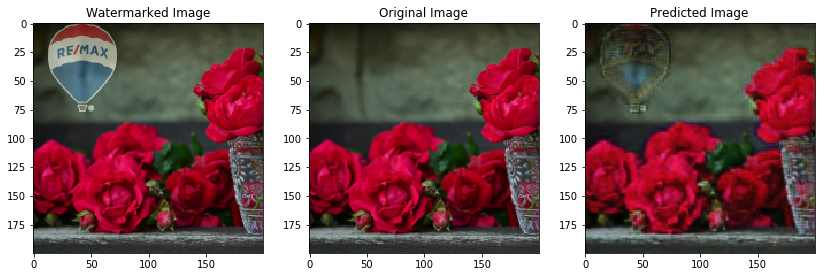

In [79]:
fig_no = 567
pred = autoencoder.predict(np.expand_dims(X_val[fig_no], axis=0))
plt.subplots(figsize=(14,7))
plt.subplot(131)
plt.title("Watermarked Image")
plt.imshow(X_val[fig_no][:,:,::-1])
plt.subplot(132)
plt.title("Original Image")
plt.imshow(y_val[fig_no][:,:,::-1])
plt.subplot(133)
plt.title("Predicted Image")
plt.imshow(pred[0][:,:,::-1])
plt.show()

# Training vs Validation Loss Plot

In [23]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'autoencoder_train' is not defined

# Predicting on Test Data

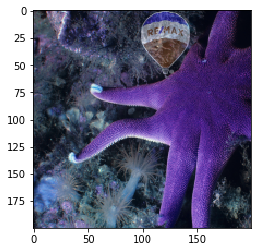

In [134]:
pred = autoencoder.predict(np.expand_dims(X[0], axis=0))
plt.imshow(pred[0][:,:,::-1])

Test Images


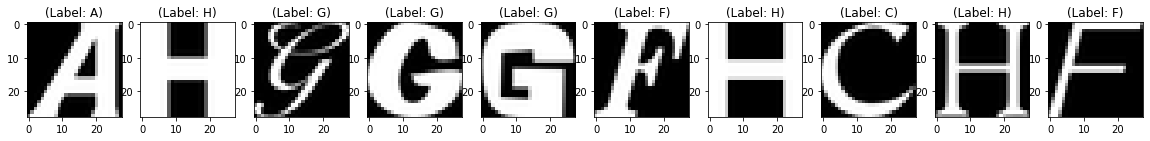

Test Images with Noise


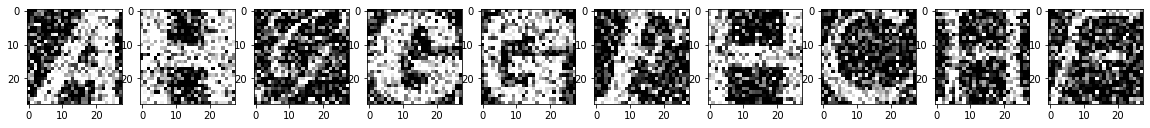

Reconstruction of Noisy Test Images


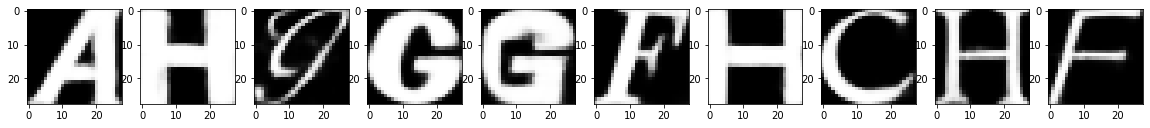

In [26]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()